In [1]:
# import libraries
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import re
from functools import *
import mplcursors

%matplotlib widget

In [2]:
# define the classes
class Point:
    id: int
    coord: np.ndarray
    dominant: int
    second_dominant: int
    values: list[float]
    tissue: bool

point_list: list[Point] = []
edge_set: set[tuple[int]] = set()
triangle_set: set[tuple[int]] = set()
tetrahedron_set: set[tuple[int]] = set()


In [3]:
# load from st data files
# points_data = pd.read_csv("assets/HT112C1/points.csv", header=None)
# tets_data = pd.read_csv("assets/HT112C1/tets.csv", header=None)

# load from toy data files
# points_data = pd.read_csv("assets/torus-points.csv")
# tets_data = pd.read_csv("assets/torus-tets.csv")

# load from new toy data files
points_data = pd.read_csv("assets/toy-data-4/points.csv", header=None)
tets_data = pd.read_csv("assets/toy-data-4/tets.csv", header=None)

# points_data = pd.read_csv("assets/small-torus/points.csv", header=None)
# tets_data = pd.read_csv("assets/small-torus/tets.csv", header=None)

if points_data.isna().any().any():
    raise ValueError("NaN values detected in the data file!")

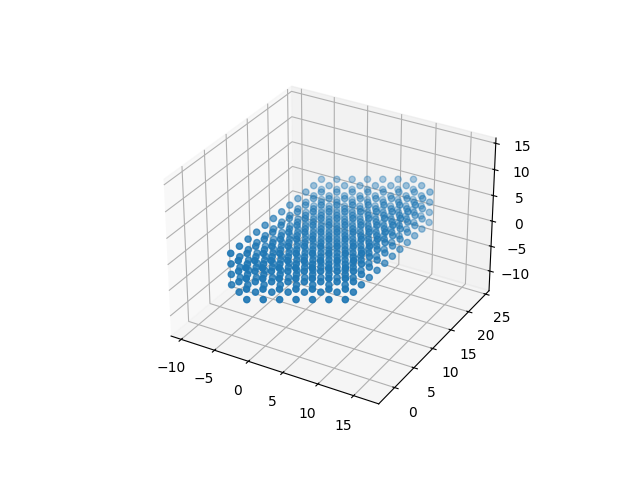

In [4]:
coords = points_data.iloc[:, :3]
x_limits = coords.iloc[:, 0].agg(["min", "max"]).tolist()
y_limits = coords.iloc[:, 1].agg(["min", "max"]).tolist()
z_limits = coords.iloc[:, 2].agg(["min", "max"]).tolist()

x_range = abs(x_limits[1] - x_limits[0])
x_middle = (x_limits[0] + x_limits[1]) / 2
y_range = abs(y_limits[1] - y_limits[0])
y_middle = (y_limits[0] + y_limits[1]) / 2
z_range = abs(z_limits[1] - z_limits[0])
z_middle = (z_limits[0] + z_limits[1]) / 2

plot_radius = 0.5 * max([x_range, y_range, z_range])

# plot the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_data.iloc[:, 0].to_numpy(), points_data.iloc[:, 1].to_numpy(), points_data.iloc[:, 2].to_numpy())
ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
plt.show()

In [5]:
num_materials = points_data.shape[1] - 3

for i, row in points_data.iterrows():
    point = Point()
    point.id = i
    point.coord = row.iloc[:3]
    values = row.iloc[3:]
    point.dominant = values.idxmax() - 3
    point.second_dominant = values.nlargest(2).iloc[1:].idxmax() - 3
    point.values = values.to_list()
    point.tissue = point.dominant != num_materials - 1
    point_list.append(point)


edge_combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
triangle_combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

for i, tet in tets_data.iterrows():
    edges = [sorted([tet.iloc[combination[0]], tet.iloc[combination[1]]]) for combination in edge_combinations]
    [edge_set.add(tuple(x)) for x in edges]
    triangles = [sorted([tet.iloc[combination[0]], tet.iloc[combination[1]], tet.iloc[combination[2]]]) for combination in triangle_combinations]
    [triangle_set.add(tuple(x)) for x in triangles]
    tetrahedron_set.add(tuple(sorted(tet)))

In [6]:
points_by_material = [[] for _ in range(num_materials)]
faces_by_material = [[] for _ in range(num_materials)]
point_index_in_material_group = {}
face_index_in_material_group = {}

for i, point in enumerate(point_list):
    points_by_material[point.dominant].append(point)
    point_index_in_material_group[i] = len(points_by_material[point.dominant]) - 1

for i, triangle in enumerate(triangle_set):
    if point_list[triangle[0]].dominant == point_list[triangle[1]].dominant and point_list[triangle[0]].dominant == point_list[triangle[2]].dominant:
        faces_by_material[point_list[triangle[0]].dominant].append(triangle)
        face_index_in_material_group[i] = len(faces_by_material[point_list[triangle[0]].dominant]) - 1

Material 0 has 480 points, 2866 edges, 4522 triangles, 2135 tets, 10003 simplices in total
Material 0 dimension 0 has 10 finite points and 1 infinite points


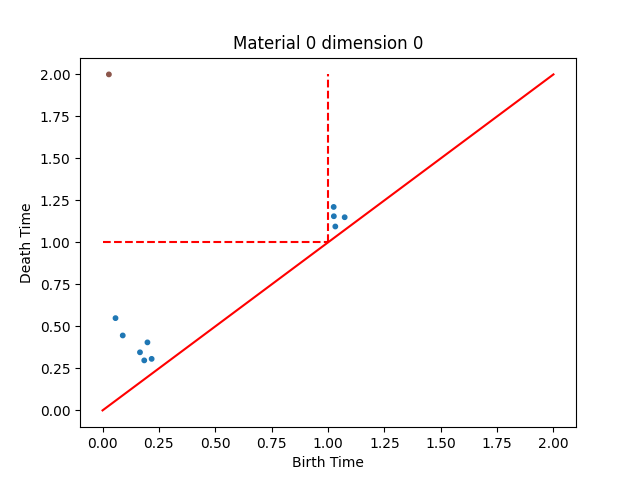

Material 0 dimension 1 has 5 finite points and 0 infinite points


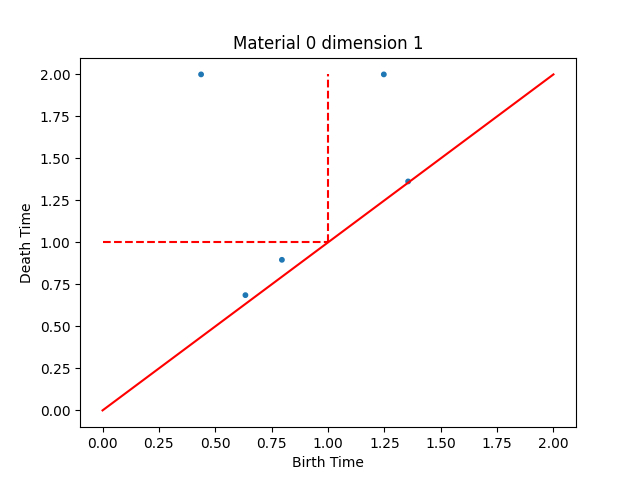

Material 0 has 48 points and 204 faces


Material 1 has 480 points, 2866 edges, 4522 triangles, 2135 tets, 10003 simplices in total
Material 1 dimension 0 has 12 finite points and 1 infinite points


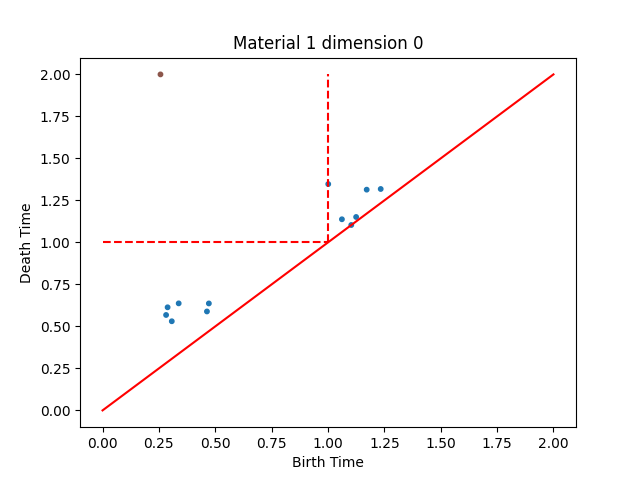

Material 1 dimension 1 has 6 finite points and 0 infinite points


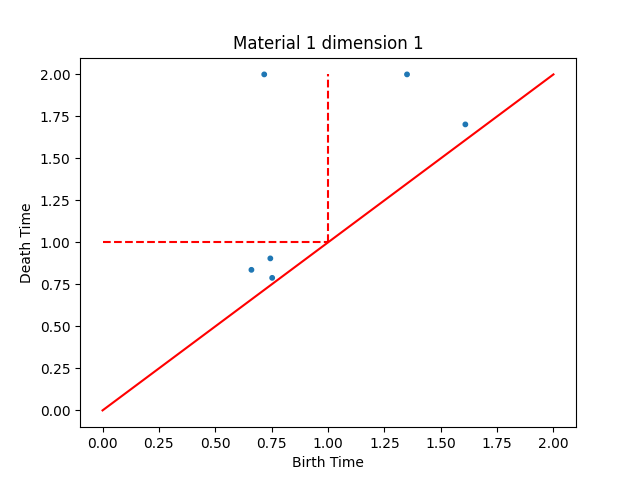

Material 1 has 48 points and 204 faces


Skipping no tissue points


In [7]:
generator_by_material_and_dimension = [[] for _ in range(num_materials)]
filtrations_by_material = [[] for _ in range(num_materials)]
ph_matrix_by_material = [[] for _ in range(num_materials)]
diagrams_by_material = [[] for _ in range(num_materials)]

def get_value(point, material):
    values = point.values
    if material == point.dominant:
        return values[point.dominant] - values[point.second_dominant]
    else:
        return values[material] - values[point.dominant]


# iterate through the materials
for material in range(num_materials):
    if len(points_by_material[material]) == 0:
        print(f"Material {material} has no points")
        continue
    elif material == num_materials - 1:
        print("Skipping no tissue points")
        continue

    points = [([point.id], 1 - get_value(point, material)) for point in point_list]
    edges = [(list(edge), 1 - min([get_value(point_list[point], material) for point in edge])) for edge in edge_set]
    triangles = [(list(triangle), 1 - min([get_value(point_list[point], material) for point in triangle])) for triangle in triangle_set]
    tets = [(list(tet), 1 - min([get_value(point_list[point], material) for point in tet])) for tet in tetrahedron_set]

    simplices = []
    simplices.extend(points)
    simplices.extend(edges)
    simplices.extend(triangles)
    simplices.extend(tets)

    print(f"Material {material} has {len(points)} points, {len(edges)} edges, {len(triangles)} triangles, {len(tets)} tets, {len(simplices)} simplices in total")

    filtration = d.Filtration()
    for vertices, time in simplices:
        filtration.append(d.Simplex(vertices, time))
    filtration.sort()

    ph_matrix = d.homology_persistence(filtration, method="column")
    diagrams = d.init_diagrams(ph_matrix, filtration)

    for i, diagram in enumerate(diagrams):
        # skip the 3-cycles (does not exist) and empty diagrams
        if i == 3 or len(diagram) == 0:
            continue

        plt.figure()
        plt.title(f"Material {material} dimension {i}")
        filtered_diagram = [pt for pt in diagram if pt.birth < pt.death]
        if len(diagram) != len(filtered_diagram):
            print(f"{len(diagram)-len(filtered_diagram)} points got filtered out")

        num_infinite_points = reduce(lambda x, y: x + 1 if y.death == float('inf') else x, filtered_diagram, 0)
        num_finite_points = len(filtered_diagram) - num_infinite_points

        print(f"Material {material} dimension {i} has {num_finite_points} finite points and {num_infinite_points} infinite points")

        # using plt.scatter instead of dionysus built in plot feature
        birth_times = list(map(lambda pt: pt.birth, filtered_diagram))
        death_times = list(map(lambda pt: pt.death if pt.death != float('inf') else 2.0, filtered_diagram))
        colors = list(map(lambda pt: 'tab:blue' if pt.death != float('inf') else 'tab:brown', filtered_diagram))
        the_scatter = plt.scatter(birth_times, death_times, s=10, color=colors)
        plt.plot([0, 2], [0, 2], "r")
        plt.plot([1, 1], [1, 2], "r--")
        plt.plot([0, 1], [1, 1], "r--")
        plt.xlabel("Birth Time")
        plt.ylabel("Death Time")
        plt.show()

        mplcursors.cursor(the_scatter).connect(
            "add", lambda sel, filtered_diagram=filtered_diagram: 
            sel.annotation.set_text(f"Simplex Index: {sel.index}\nBirth: {filtered_diagram[sel.index].birth:.2f}\nDeath: {filtered_diagram[sel.index].death:.2f}")
        )


    # dictionary to reverse lookup the killer of a cycle
    pairs = {}
    for j in range(len(ph_matrix)):
        if ph_matrix.pair(j) != ph_matrix.unpaired:
            pairs[ph_matrix.pair(j)] = j


    # finding the generators for 1 and 2 cycle
    diagrams_sorted = [[] for _ in range(4)]
    generators_by_dimension = [None for _ in range(4)]
    for dimension, diagram in enumerate(diagrams):
        generators = []
        diagram_sorted = sorted(list(filter(lambda x: x[1] != float("inf"), map(lambda x: (x, x.death - x.birth), diagram))), reverse=True, key=lambda x: x[1])
        diagrams_sorted[dimension] = diagram_sorted
        for (point, lifespan) in diagram_sorted:
            if point.birth > 1.0 or point.death < 1.0 or point.death == float("inf"):
                continue

            generator = [[int(s) for s in re.findall(r'<(.*?)>', str(filtration[int(index)]))[0].split(',')] for index in re.findall(r'\*(\d+)', str(ph_matrix[pairs.get(point.data)]))] if pairs.get(point.data) != None else []
            generators.append((generator, point.death - point.birth))
        generators_by_dimension[dimension] = [g[0] for g in generators]
    generator_by_material_and_dimension[material] = generators_by_dimension

    vertices = [list(point.coord) for point in points_by_material[material]]
    intensities = [point.values[material] for point in points_by_material[material]]
    faces = [[point_index_in_material_group[v] for v in face] for face in faces_by_material[material]]

    num_one_cycles = len(generators_by_dimension[1])
    num_two_cycles = len(generators_by_dimension[2])
    one_cycles_lengths = [len(loop) for loop in generators_by_dimension[1]]
    two_cycles_lengths = [len(loop) for loop in generators_by_dimension[2]]
    total_num_edges = reduce(lambda x, y: x + y, one_cycles_lengths) if num_one_cycles else 0
    total_num_triangles = reduce(lambda x, y: x + y, two_cycles_lengths) if num_two_cycles else 0

    one_cycle_index_range = []
    two_cycle_index_range = []
    accumulation = 0
    for length in one_cycles_lengths:
        if length: 
            index_range = (accumulation, accumulation + length - 1)
        else:
            index_range = (-1, -1)
        one_cycle_index_range.append(index_range)
        accumulation += length
    for length in two_cycles_lengths:
        if length: 
            index_range = (accumulation, accumulation + length - 1)
        else:
            index_range = (-1, -1)
        two_cycle_index_range.append(index_range)
        accumulation += length
    

    if len(faces) == 0: 
        print(f"Material {material} has {len(vertices)} but no faces, 3D mesh display skipped")
        continue
    else:
        print(f"Material {material} has {len(vertices)} points and {len(faces)} faces")

    x, y, z = zip(*vertices)
    i, j, k = zip(*faces)

    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=intensities, colorscale=[[0, 'navy'], [0.25, 'cyan'], [0.5, 'lime'], [0.75, 'yellow'], [1, 'red']], opacity=0.01)])

    edge_range = (1, total_num_edges)
    triangle_range = (total_num_edges + 1, total_num_edges + total_num_triangles)
    visibility = [True] * (total_num_edges + total_num_triangles + 1)

    # target: show only the specified simplex by its index, -1 to show everything, -2 to show nothing
    # mode: 1 for edge, 2 for triangle
    def set_visibility(target, mode, visibility):
        if mode == 1:
            if target == -1:
                new_visibility = [True] + [True] * total_num_edges + visibility[triangle_range[0]:triangle_range[1]+1]
            elif target == -2:
                new_visibility = [True] + [False] * total_num_edges + visibility[triangle_range[0]:triangle_range[1]+1]
            else: 
                new_visibility = [True] + [one_cycle_index_range[target][0] <= e <= one_cycle_index_range[target][1] for e in range(total_num_edges)] + visibility[triangle_range[0]:triangle_range[1]+1]
        elif mode == 2:
            if target == -1:
                new_visibility = [True] + visibility[edge_range[0]:edge_range[1]+1] + [True] * total_num_triangles
            elif target == -2:
                new_visibility = [True] + visibility[edge_range[0]:edge_range[1]+1] + [False] * total_num_triangles
            else: 
                new_visibility = [True] + visibility[edge_range[0]:edge_range[1]+1] + [two_cycle_index_range[target][0] <= e <= two_cycle_index_range[target][1] for e in range(total_num_triangles)]
        visibility = new_visibility
        return visibility

    sliders = [{
        'steps': [
            {
                'label': f'{opacity:.1f}',
                'method': 'restyle',
                'args': [{'opacity': opacity}, [0]]
            } for opacity in [i/10 for i in range(1, 11)]
        ],
        'currentvalue': {'prefix': 'Opacity: ', 'font': {'size': 20}},
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'xanchor': 'left',
        'y': -0.1,  
        'yanchor': 'top'
    },
    {
        'active': 0,
        'currentvalue': {'prefix': '1-cycle: ', 'font': {'size': 20}},
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'xanchor': 'left',
        'y': -0.5, 
        'yanchor': 'top',
        'steps': [
            {
                'label': 'All',
                'method': 'update',
                'args': [{'visible': set_visibility(-1, 1, visibility)}]
            }
        ] + [
            {
                'label': f'{i+1}',
                'method': 'update',
                'args': [{'visible': set_visibility(i, 1, visibility)}]
            } for i in range(min(num_one_cycles, 10))
        ] + [
            {
                'label': 'None',
                'method': 'update',
                'args': [{'visible': set_visibility(-2, 1, visibility)}]
            }
        ]
    },
    {
        'active': 0,
        'currentvalue': {'prefix': '2-cycle: ', 'font': {'size': 20}},
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'xanchor': 'left',
        'y': -0.9, 
        'yanchor': 'top',
        'steps': [
            {
                'label': 'All',
                'method': 'update',
                'args': [{'visible': set_visibility(-1, 2, visibility)}]
            }
        ] + [
            {
                'label': f'{i+1}',
                'method': 'update',
                'args': [{'visible': set_visibility(i, 2, visibility)}]
            } for i in range(min(num_two_cycles, 10))
        ] + [
            {
                'label': 'None',
                'method': 'update',
                'args': [{'visible': set_visibility(-2, 2, visibility)}]
            }
        ]
    }
    ]

    updatemenus=[{
        'type': 'buttons',
        'buttons': [
            {
                'label': 'Opacity 0.01',
                'method': 'restyle',
                'args': [{'opacity': 0.01}, [0]]
            },
            {
                'label': 'Opacity 0.1',
                'method': 'restyle',
                'args': [{'opacity': 0.1}, [0]]
            },
            {
                'label': 'Opacity 1.0',
                'method': 'restyle',
                'args': [{'opacity': 1.0}, [0]]
            }
        ]
    }]

    fig.update_layout(scene=dict(
        xaxis=dict(range=[x_middle - plot_radius, x_middle + plot_radius]),
        yaxis=dict(range=[y_middle - plot_radius, y_middle + plot_radius]),
        zaxis=dict(range=[z_middle - plot_radius, z_middle + plot_radius]),
        aspectmode='manual'),
        title_text=f"Material {material}",
        width=800,
        height=600,
        updatemenus=updatemenus,
        sliders=sliders
    )

    def plot_edge(fig, edge):
        edge = [list(point_list[endpoint].coord) for endpoint in edge]
        fig.add_trace(go.Scatter3d(
            x=[edge[0][0], edge[1][0], None], 
            y=[edge[0][1], edge[1][1], None], 
            z=[edge[0][2], edge[1][2], None],
            mode='lines',
            showlegend=False,
            line=dict(color='black', width=5),
            name="edges"
        ))

    def plot_triangle(fig, triangle):
        vertices = [list(point_list[endpoint].coord) for endpoint in triangle]
        fig.add_trace(go.Mesh3d(
            x=[vertices[0][0], vertices[1][0], vertices[2][0]],
            y=[vertices[0][1], vertices[1][1], vertices[2][1]],
            z=[vertices[0][2], vertices[1][2], vertices[2][2]],
            i=[0],
            j=[1],
            k=[2],
            color='grey',
            opacity=0.4,
            name="triangles"
        ))

    # display the edges of 1 and 2 cycles
    [[plot_edge(fig, edge) for edge in loop ] for loop in generators_by_dimension[1]]
    [[plot_triangle(fig, triangle) for triangle in loop ] for loop in generators_by_dimension[2]]
    fig.show()


    filtrations_by_material[material] = filtration
    ph_matrix_by_material[material] = ph_matrix
    diagrams_by_material[material] = diagrams